In [28]:
# Load relevant R packages
inLibraries = list('repr','rgdal','spdep','classInt','GISTools','maptools','RColorBrewer')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))      
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

In [41]:
#Read in the featureclass
polyFeatures <- readOGR("datasets/newyork_cancer", "NYzipUTM")

OGR data source with driver: ESRI Shapefile 
Source: "datasets/newyork_cancer", layer: "NYzipUTM"
with 1384 features
It has 8 fields
Integer64 fields read as strings:  PRIMARY ObsIncid 


In [42]:
peek <- head(polyFeatures@data)
peek

,PRIMARY,COUNT,MalePop,ObsIncid,CRate,test,CRate2,crate3
0,0,3,0,0,0.000000000,0,NA,NA
1,10001,1,9570,54,0.005642633,0,0.00564263,0.00564263
2,10002,1,37830,190,0.005022469,0,0.00502247,0.00502247
3,10003,1,25524,160,0.006268610,0,0.00626861,0.00626861
4,10005,3,2283,9,0.003942181,0,0.00394218,0.00394218
5,10007,1,5256,13,0.002473364,0,0.00247336,0.00247336


In [43]:
data <- polyFeatures@data

### Visualize the Zip Code Areas

Map the zip code polygons so that you can visualize the features. Add a north arrow and scale bar for perspective. There are a variety of R libraries that can be used to add such map elements. For example, the sp library has some basic functions. Prettymapr has some quick and easy options, but doesn't offer much flexibility for positioning the elements. GISTools allows for more precise positioning, but requires specification of position in terms of map units (vs plot units) which can be more tedious. Regardless of the library used, the outputs are still a bit cheesy. In this case, the use of GISTools library is demonstrated. GISTools also needs to access function in the maptools and RColorBrewer libraries so those need to be added as well.  

To add a north arrow and scale bar, a reference point is needed to position the element. In the example below, the extent (bounding box) of the polygons is used to retrieve the lower left coordinate of the bounding box. To add the north arrow, the north.arrow() function (GISTools library) can be used. To add the scale bar, the map.scale() function (GISTools library) can be used. Since the CRS is in meters, the positional,size arguements in the north arrow and scale bar must also be in meters. As you will see, the x and y anchor points for these elements were adjusted by some number so that they were positioned where I wanted them.

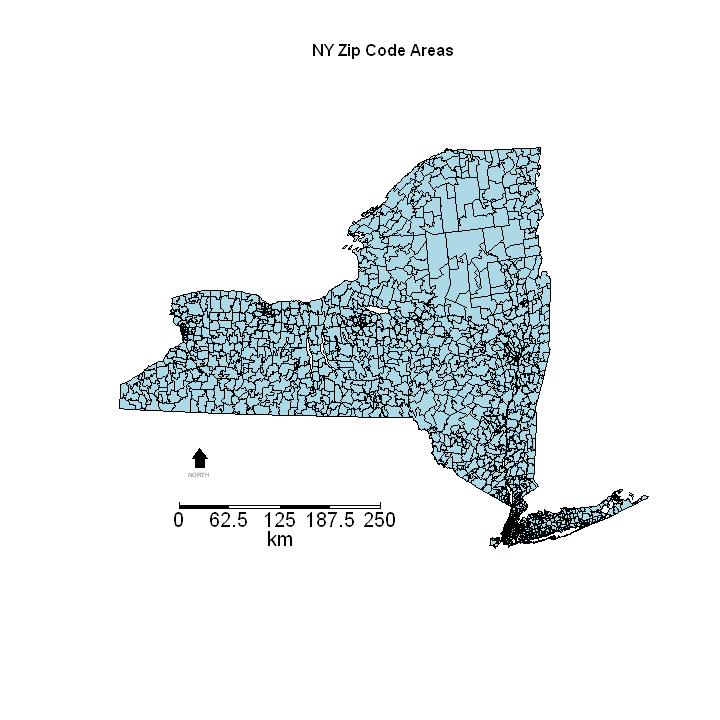

In [32]:
#plot the zip code polygon features
plot(polyFeatures, col = 'lightblue', lwd = 0.2, main = "NY Zip Code Areas", cex.main = 0.8)

#add north arrow
ext <- bbox(polyFeatures)
xb <- ext[1,1]
yb <- ext[2,1]
north.arrow(xb + 100000, yb + 100000, len = 6000, lab = 'NORTH', cex.lab = .3, tcol = 'black', col = 'black')

#add scale bar
xc <- xb
yc <- yb
len <- 250000
ndivs <- 4
subdiv <- (len/1000)/ndivs
map.scale(xc + 200000, yc + 50000, len, units = 'km', ndivs, subdiv, tcol = 'black', scol = 'black', sfcol = 'black')

## Feature Attribute to Analyze

In most geostatistical methods, an attribute(s) of a feature is to be analysed/displayed. For the New York dataset, we are evaluating prostate cancer incidence 'ObsIncid' which is the number of recorded occurences in the resident population. Given that the population can vary among the reporting areas (zip code areas in this case), it might be good to normalize the observations of cancer by the population of each area....something known as population density. However, since prostate cancer is likely limited to males, we can limit the population to the male population 'MalePop'.

Note: If there are any cases where no male population exists in an area, then a division by zero problem could be encountered. To avoid this, NA values can be tested for in the result and replaced with zeros.

In [39]:
peek

,PRIMARY,COUNT,MalePop,ObsIncid,CRate,test,CRate2,crate3
0,0,3,0,0,0.000000000,0,NA,NA
1,10001,1,9570,54,0.005642633,0,0.00564263,0.00564263
2,10002,1,37830,190,0.005022469,0,0.00502247,0.00502247
3,10003,1,25524,160,0.006268610,0,0.00626861,0.00626861
4,10005,3,2283,9,0.003942181,0,0.00394218,0.00394218
5,10007,1,5256,13,0.002473364,0,0.00247336,0.00247336


In [40]:
str(peek)

'data.frame':	6 obs. of  8 variables:
 $ PRIMARY : Factor w/ 1384 levels "0","10001","10002",..: 1 2 3 4 5 6
 $ COUNT   : num  3 1 1 1 3 1
 $ MalePop : num  0 9570 37830 25524 2283 ...
 $ ObsIncid: Factor w/ 236 levels "0","1","10","100",..: 1 188 95 68 227 36
 $ CRate   : num  0 0.00564 0.00502 0.00627 0.00394 ...
 $ test    : num  0 0 0 0 0 0
 $ CRate2  : num  NA 0.00564 0.00502 0.00627 0.00394 ...
 $ crate3  : num  NA 0.00564 0.00502 0.00627 0.00394 ...


In [48]:
# retrieve variables
inVa <- as.numeric(polyFeatures$ObsIncid) # number of recorded occurences in the resident population
inVb <- as.numeric(polyFeatures$MalePop) # male population

In [54]:
#incident rate variables
VarA <- (inVa/inVb)

#if a variable is Null/NaN, set to zero so there are no missing values
VarA[is.nan(VarA)] <- 0
VarA[!is.finite(VarA)] <- 0

In [55]:
VarA[1:10]

[1] 0.000000000 0.019644723 0.002511234 0.002664159 0.099430574 0.006849315
 [7] 0.002010916 0.018920929 0.002007444 0.016078210

In [56]:
length(VarA)

[1] 1384

In [57]:
length(data$MalePop)

[1] 1384

## Data Classification

Given a continuous numerical variable, any number of categorization schemes can be applied. Each categorization scheme can convey a different message. As such, it is important to consider the alternatives and choose the one that best renders the variable of interest. The classIntervals library provides a range of data classification techniques that can be easily applied to your data.  


Let's consider a few for mapping data. The classIntervals() function requires the name of the variable, the desired number of classes, and the style or type of classification. After the classInterval() function is applied, then findColours() (classIntervals library) can be called to assign a color scheme from 'colorRampPalette' to the classes identified.

One of the variable returned by classIntervals() is 'brks', a vector of the values used to define breaks in the classification scheme. The paste() function can be used to generate a table of text break ranges. You might ask yourself how paste(brks.dec[-numcat], brks.dec[-1], sep=" - ") is able to accomplish this. The key is the - argument in [-numcat] and [-1]. A good resource for referencing tricks like this is: https://cran.r-project.org/doc/contrib/Short-refcard.pdf

In [58]:
#Configure classification parameters
numcat <- 6
cate <- classIntervals(VarA, numcat, style="equal")

In [59]:
names(cate)

[1] "var"  "brks"

In [60]:
length(cate$var)

[1] 1384

In [61]:
cate$brks

[1] 0.0000000 0.2996454 0.5992908 0.8989362 1.1985816 1.4982270 1.7978723

In [62]:
#assign colors to categories
pal <- gray.colors(numcat)
cols <- findColours(cate, pal)

In [63]:
pal

[1] "#4D4D4D" "#7F7F7F" "#A0A0A0" "#BBBBBB" "#D1D1D1" "#E6E6E6"

In [64]:
cols[1:20]

[1] "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D"
 [8] "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D"
[15] "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D" "#4D4D4D"

In [65]:
cate$var[1:20]

[1] 0.000000000 0.019644723 0.002511234 0.002664159 0.099430574 0.006849315
 [7] 0.002010916 0.018920929 0.002007444 0.016078210 0.015241832 0.001092966
[13] 0.002316765 0.028292545 0.086773700 0.001731730 0.009266886 0.006609338
[19] 0.003718515 0.005429318

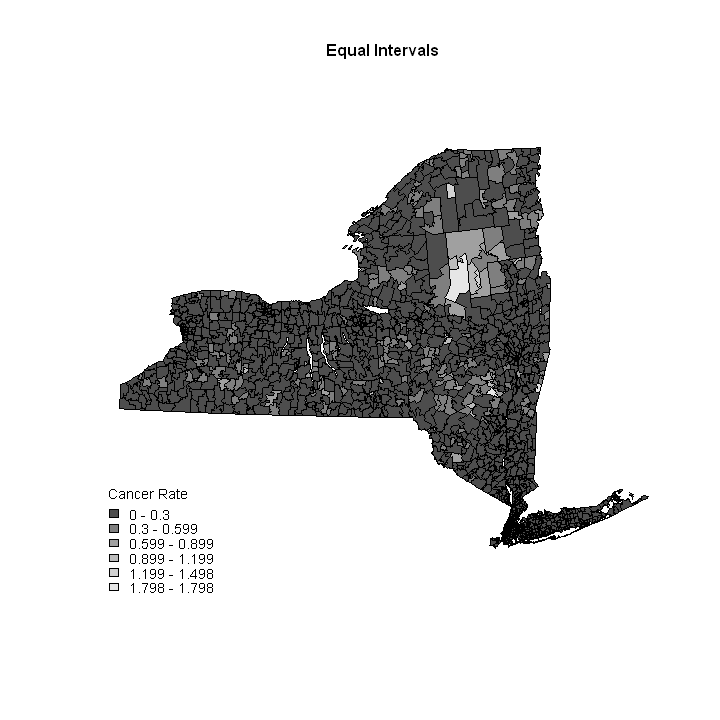

In [66]:
#Map classification scheme

decimalPlaces <- 3

plot(polyFeatures, col = cols, lwd = 0.2, main = "Equal Intervals",cex.main = 0.8)

brks.dec <- round(cate$brks,decimalPlaces)

leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")

legend("bottomleft", fill = attr(cols, "palette"), legend = leg.text, 
               bty = "n", title = "Cancer Rate", cex = 0.7)

### Quantiles

Quantiles reflect a partioning of the dataset into categories containing roughly similar numbers of observations.

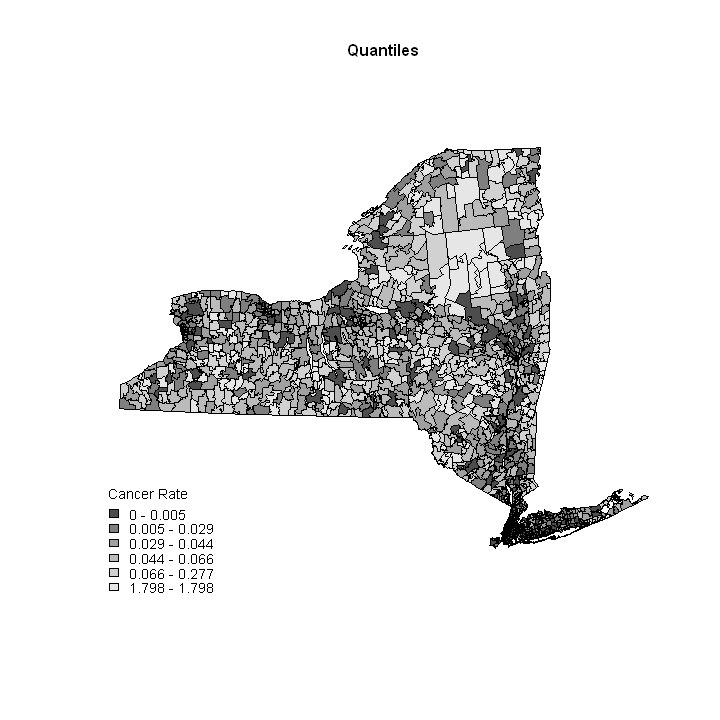

In [67]:
#Configure classification parameters

numcat <- 6
cate <- classIntervals(VarA, numcat, style = "quantile")

#assign colors to categories

pal <- gray.colors(numcat)
cols <- findColours(cate, pal)

#Map classification scheme

decimalPlaces <- 3

plot(polyFeatures, col = cols, lwd = 0.2, main = "Quantiles", cex.main = 0.8)

brks.dec <- round(cate$brks, decimalPlaces)

leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")

legend("bottomleft", fill = attr(cols,"palette"), 
       legend = leg.text, bty = "n", title = "Cancer Rate", cex = 0.7)

### k-means

kmeans() involves the use of a clustering algorithm to associate the data with one of k categories. As such, there is a possibility that it can get stuck in a local optimal when trying to reach a globally optimal solution. To address this potential problem, the 'rtimes' parameter can be set to configure the number of times to re-evaluate the variable when assessing potential classification schemes.

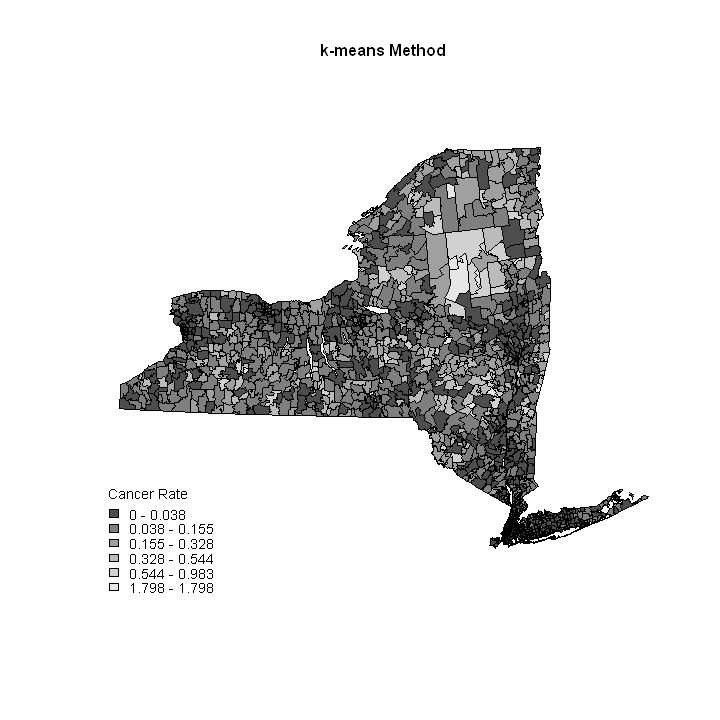

In [68]:
#Configure classification parameters
numcat <- 6
repeattimes <- 25
cate <- classIntervals(VarA, numcat, style = "kmeans", rtimes = repeattimes)

#assign colors to categories
pal <- gray.colors(numcat)
cols <- findColours(cate, pal)

#map classification scheme
decimalPlaces <- 3
plot(polyFeatures, col = cols, lwd = 0.2, main = "k-means Method", cex.main = 0.8)
brks.dec <- round(cate$brks,decimalPlaces)
leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")

legend("bottomleft", fill = attr(cols,"palette"), legend = leg.text,
                           bty = "n", title = "Cancer Rate", cex = 0.7)

### Jenks Methods

jenks() is an other algorithmic method for identifying 'natural' breaks in the dataset. For the jenks method, a goodness-of-fit metric (jenks.tests()) is offered by classIntervals. This metric allows one to assess how well the number of classes represent the characteristics of the data. This method is more computationally demanding, so you may notice that it takes longer to complete than the other methods.

# classes  Goodness of fit Tabular accuracy 
       6.0000000        0.9636304        0.7979838

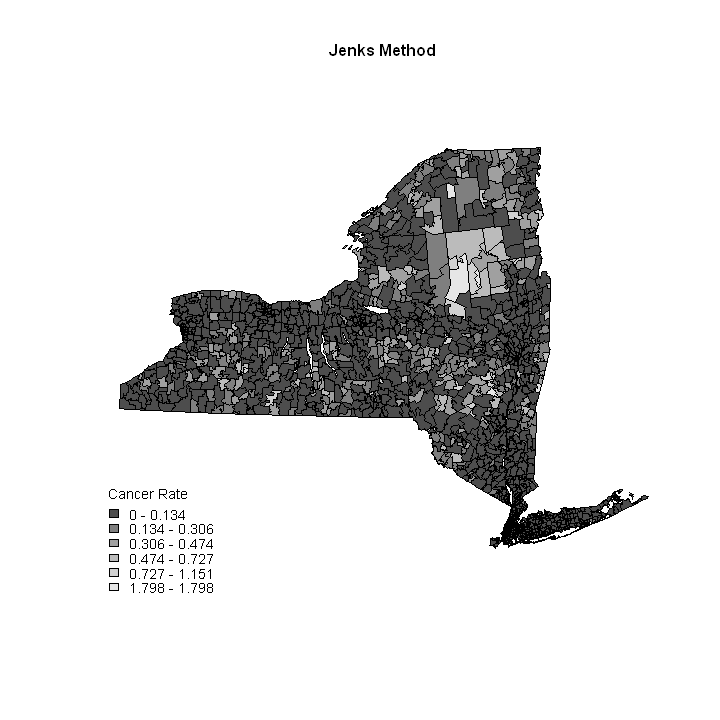

In [69]:
#Configure classification parameters
numcat <- 6
cate <- classIntervals(VarA, numcat, style = "jenks")

#test jenks categories for goodness of fit
jenksTestResults <- jenks.tests(cate)
jenksTestResults

#assign colors to categories
pal <- gray.colors(numcat)
cols <- findColours(cate,pal)

#map classification scheme
decimalPlaces <- 3
plot(polyFeatures, col = cols, lwd=.2, main="Jenks Method",cex.main=.8)
brks.dec <- round(cate$brks,decimalPlaces)
leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Cancer Rate",cex=.7)

### Bagged Cluster

hclust() also involves the use of an algorithm. As such, there is a possibility that it can get stuck when trying to reach a optimal solution. To address this potential problem, the 'rtimes' parameter can be set to configure the number of times to re-evaluate the variable when assessing potential classification schemes.

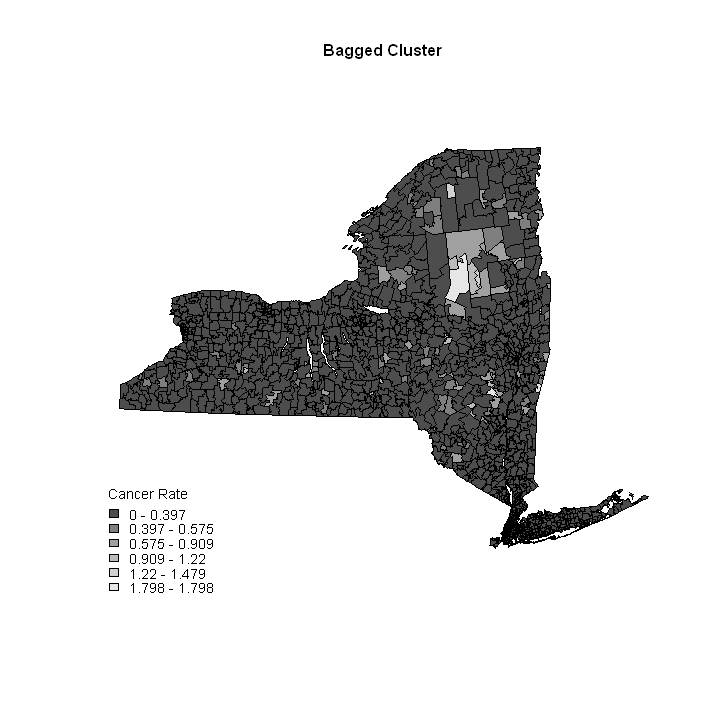

In [70]:
#Configure classification parameters
numcat <- 6
repeattimes <- 25
cate <- classIntervals(VarA, numcat, style="hclust", rtimes=repeattimes)

#assign colors to categories
pal <- gray.colors(numcat)
cols <- findColours(cate,pal)

#Map classification scheme
decimalPlaces <- 3
plot(polyFeatures,col=cols, lwd=.2, main="Bagged Cluster",cex.main=.8)
brks.dec <- round(cate$brks,decimalPlaces)
leg.text <- paste(brks.dec[-numcat], brks.dec[-1], sep=" - ")
legend("bottomleft",fill=attr(cols,"palette"),legend=leg.text,bty="n",title="Cancer Rate",cex=.7)